In [18]:
import numpy as np
%matplotlib inline
import pickle
import os
import matplotlib.pyplot as plt

In [19]:
# 激活函数及其导数
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# ELU激活函数
def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))


# 均方误差损失函数及其导数
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


# MLP类定义
class MLPRegressor:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, learning_rate, l2_reg=0.01, batch_size=32, dropout_rate=0.5):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        # 初始化权重和偏置
        # self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        # self.b1 = np.zeros((1, hidden_size1))
        # self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        # self.b2 = np.zeros((1, hidden_size2))
        # self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        # self.b3 = np.zeros((1, output_size))
        
        # Xavier/Glorot初始化
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(1. / input_size)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(1. / hidden_size1)
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(1. / hidden_size2)
        self.b1 = np.ones((1, hidden_size1)) * 0.01
        self.b2 = np.ones((1, hidden_size2)) * 0.01
        self.b3 = np.ones((1, output_size)) * 0.01

        # dropout_rate初始化
        self.dropout_rate = dropout_rate
        self.dropout_mask1 = None
        self.dropout_mask2 = None

    def forward(self, X, training=True):
        # 前向传播
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = elu(self.z1)
        # Dropout层1
        if training:
            self.dropout_mask1 = np.random.binomial(1, 1 - self.dropout_rate, size=self.a1.shape) / (1 - self.dropout_rate)
            self.a1 *= self.dropout_mask1
            
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = elu(self.z2)
        # Dropout层2
        if training:
            self.dropout_mask2 = np.random.binomial(1, 1 - self.dropout_rate, size=self.a2.shape) / (1 - self.dropout_rate)
            self.a2 *= self.dropout_mask2
            
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.z3  # 输出层
        return self.a3

    def backward(self, X, y):
        m = X.shape[0]  # 当前批量的样本数
        y = y.reshape(-1, 1)
        # 计算输出层的梯度
        d_loss_a3 = self.a3 - y

        # 计算第三层的梯度  
        d_loss_W3 = np.dot(self.a2.T, d_loss_a3) / m + self.l2_reg * self.W3
        d_loss_b3 = np.sum(d_loss_a3, axis=0, keepdims=True) / m

        # 计算第二层的梯度
        d_loss_z2 = np.dot(d_loss_a3, self.W3.T) * elu_derivative(self.z2)
        d_loss_z2 *= self.dropout_mask2
        
        d_loss_W2 = np.dot(self.a1.T, d_loss_z2) / m + self.l2_reg * self.W2
        d_loss_b2 = np.sum(d_loss_z2, axis=0, keepdims=True) / m

        # 计算第一层的梯度
        d_loss_z1 = np.dot(d_loss_z2, self.W2.T) * elu_derivative(self.z1)
        d_loss_z1 *= self.dropout_mask1
        d_loss_W1 = np.dot(X.T, d_loss_z1) / m + self.l2_reg * self.W1
        d_loss_b1 = np.sum(d_loss_z1, axis=0, keepdims=True) / m

        # 更新权重和偏置
        self.W3 -= self.learning_rate * d_loss_W3
        self.b3 -= self.learning_rate * d_loss_b3
        self.W2 -= self.learning_rate * d_loss_W2
        self.b2 -= self.learning_rate * d_loss_b2
        self.W1 -= self.learning_rate * d_loss_W1
        self.b1 -= self.learning_rate * d_loss_b1

    def train(self, X, y, epochs):
        n_samples = X.shape[0]
        losses = []  # 用于存储每个epoch的损失值
    
        for epoch in range(1, epochs + 1):
            # 随机打乱数据
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
    
            # 小批量梯度下降
            for i in range(0, n_samples, self.batch_size):
                end = i + self.batch_size
                if end > n_samples:
                    end = n_samples
                X_batch = X[i:end]
                y_batch = y[i:end]
                output = self.forward(X_batch)
                loss = mean_squared_error(y_batch, output)
                self.backward(X_batch, y_batch)
    
            # 计算并存储整个数据集的损失
            output = self.forward(X)
            loss = mean_squared_error(y, output)
            losses.append(loss)  # 添加损失值到列表
    
            # 打印损失信息
            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f'Epoch {epoch}, Loss: {loss:.4f}')
    
        # 绘制损失曲线
        plt.plot(range(1, epochs + 1), losses, label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

    def predict(self, X):
        output = self.forward(X)
        return output

    def save_weights(self, file_path):
        weights = {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2,
            'W3': self.W3,
            'b3': self.b3
        }
        # 获取文件目录
        directory = os.path.dirname(file_path)
        # 如果目录不存在，则创建目录
        if not os.path.exists(directory):
            os.makedirs(directory)
        # 保存权重
        with open(file_path, 'wb') as file:
            pickle.dump(weights, file)

    def load_weights(self, file_path):
        with open(file_path, 'rb') as file:
            weights = pickle.load(file)
            self.W1 = weights['W1']
            self.b1 = weights['b1']
            self.W2 = weights['W2']
            self.b2 = weights['b2']
            self.W3 = weights['W3']
            self.b3 = weights['b3']

    def r2_score(self, y, output):
        # Calculate the total sum of squares (proportional to the variance of the data)
        total_sum_of_squares = np.sum((y - np.mean(y)) ** 2)

        # Calculate the residual sum of squares
        residual_sum_of_squares = np.sum((y - output) ** 2)

        # Handle edge case where total_sum_of_squares is zero
        if total_sum_of_squares == 0:
            raise ValueError("The total sum of squares is zero, which may indicate that all true values are identical.")

        # Calculate R^2 score
        r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

        return r2


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

# 加载加州房价数据集
housing = fetch_california_housing()
X, y = housing.data, housing.target

# 将数据分割成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1, Loss: 4.6949
Epoch 10, Loss: 3.1050
Epoch 20, Loss: 2.8765
Epoch 30, Loss: 2.6879
Epoch 40, Loss: 2.5062
Epoch 50, Loss: 2.3741
Epoch 60, Loss: 2.2358
Epoch 70, Loss: 2.1348
Epoch 80, Loss: 2.0542
Epoch 90, Loss: 1.9795
Epoch 100, Loss: 1.9130
Epoch 110, Loss: 1.8528
Epoch 120, Loss: 1.8007


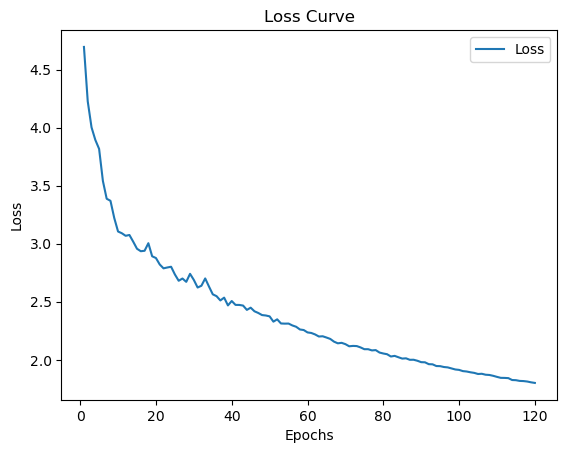

In [21]:
# 创建MLP模型
mlp = MLPRegressor(input_size=X_train_scaled.shape[1], hidden_size1=1024, hidden_size2=512, output_size=1,
                   learning_rate=0.00005, l2_reg=0.5, batch_size=32, dropout_rate=0.6)
# 训练MLP模型
mlp.train(X_train_scaled, y_train, epochs=120)
#
# 保存训练后的权重
mlp.save_weights('./weight/mlp_weights.pkl')

In [22]:
from sklearn.metrics import mean_squared_error

# 随机选择样本进行预测
random_indices = np.random.choice(X_test_scaled.shape[0], 10, replace=False)
selected_features = X_test_scaled[random_indices]
selected_targets = y_test[random_indices]

# 使用模型进行预测
predictions = mlp.predict(selected_features)

# 打印预测结果和真实值
for i, index in enumerate(random_indices):
    print(f"样本 {index}:")
    print(f"预测值: {predictions[i]}")
    print(f"真实值: {selected_targets[i]}\n")

# 计算测试集上的MSE
mse = mean_squared_error(y_test, mlp.predict(X_test_scaled))
print(f"均方误差 (MSE): {mse}")

样本 3137:
预测值: [2.36548328]
真实值: 3.169

样本 2359:
预测值: [0.9752985]
真实值: 1.44

样本 3717:
预测值: [2.29030359]
真实值: 2.727

样本 2621:
预测值: [1.58558793]
真实值: 2.284

样本 763:
预测值: [2.81186648]
真实值: 4.42

样本 777:
预测值: [1.5661193]
真实值: 0.94

样本 2996:
预测值: [1.57553046]
真实值: 1.306

样本 2369:
预测值: [1.6958073]
真实值: 1.322

样本 1907:
预测值: [1.56308508]
真实值: 1.775

样本 3062:
预测值: [1.4158338]
真实值: 1.875
均方误差 (MSE): 0.6617078402027587
